In [40]:
import numpy as np
import pandas as pd
import pickle
import string
import re
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.manifold import TSNE
from gensim.models import word2vec

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# pd.set_option("display.max_columns", 2000)
# pd.set_option("display.max_rows", 2000)
# pd.set_option("max_colwidth", 200)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_videos_cleaned_v8 = pickle.load(open('../Data/df_videos_cleaned_v8.pickle', 'rb'))

### All the functions (Need to put these into a separate .py file)

In [3]:
def title_preprocessing(df):
    '''
    Input: Cleaned dataframe 
    Output: Tokenized titles in the dataframe 
    '''
    df_copy = df.copy()
    
    def preprocessing_pipeline(raw_text):
        ## Remove punctuations, except for apostrophes
        preprocessed_text_1 = raw_text.translate(str.maketrans('', '', string.punctuation.replace("'", "")))
        
        ## Remove numbers
        preprocessed_text_2 = re.sub('\w*\d\w*', '', preprocessed_text_1)
        
        ## Remove stopwords
        stopwords = spacy.lang.en.stop_words.STOP_WORDS
        
        preprocessed_text_3 = nlp(preprocessed_text_2)
        preprocessed_text_4 = [word.text for word in preprocessed_text_3 
                                    if str(word).lower() not in stopwords and word.text!= ' ']
        
        ## Lemmatization
        lemmatizer = WordNetLemmatizer()
        tag_map = defaultdict(lambda : wordnet.NOUN)
        tag_map['V'] = wordnet.VERB 
        tag_map['J'] = wordnet.ADJ
        tag_map['R'] = wordnet.ADV

        preprocessed_text_5 = [lemmatizer.lemmatize(word.lower(), tag_map[tag[0]]) 
                                    for word, tag in pos_tag(preprocessed_text_4)]
        
        preprocessed_text_6 = [word for word in preprocessed_text_5 if len(word)>1]
        
        return preprocessed_text_6
    
    df_copy['Title'] = df_copy['Title'].apply(preprocessing_pipeline)
            
    return df_copy   

In [4]:
def wordcloud(df, text_column):
    '''
    Input: Cleaned dataframe 
    Output: a Wordcloud viz showing most frequently represented words
    '''
    ## Take the words out of the (word, POS) tuple, count-vectorize, and fit-transform into a matrix
    if text_column == 'Transcript':
        word_list = [[word[0] for word in doc] for doc in df['Transcript']]
    elif text_column == 'Title':
        word_list = [[word for word in doc] for doc in df['Title']]
        
    vec = CountVectorizer(tokenizer=lambda doc:doc, lowercase=False, min_df=2, max_df=0.3)
    matrix = vec.fit_transform(word_list).toarray()
    
    ## A list of words sorted by word frequency in the text
    sum_words = matrix.sum(axis=0)
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x:x[1], reverse=True)[2:]
    
    wordcloud = WordCloud(width=400, height=330, max_words=150,colormap="Dark2")
    
    wordcloud.generate_from_frequencies(dict(words_freq))

    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

In [27]:
def word2vec_plot(df, text_column, min_count, window):
    '''
    Input: Cleaned dataframe 
    Output: A t-SNE plot showing clusters based on Word2Vec embeddings
    '''
    ## Take the words out of the (word, POS) tuple in each transcript and put them into a list
    if text_column == 'Transcript':
        word_list = [[word[0] for word in doc] for doc in df['Transcript']]
    elif text_column == 'Title':
        word_list = [[word for word in doc] for doc in df['Title']]
    
    ## Initialize a Word2Vec model and set parameters
    model = word2vec.Word2Vec(word_list, min_count=min_count, window=window, ns_exponent = -10)
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    ## Create a plot using matplotlib
    plt.figure(figsize=(16, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    plt.tight_layout()
    plt.savefig('../Charts/word2vec_tsne_plot', dpi=600)

In [6]:
def word2vec_most_similar(df, text_column, min_count, window, word):
    '''
    Input: Cleaned dataframe 
    Output: 10 most similar words based on Word2Vec embeddings
    '''
    if text_column == 'Transcript':
        word_list = [[text[0] for text in doc] for doc in df['Transcript']]
    elif text_column == 'Title':
        word_list = [[text for text in doc] for doc in df['Title']]
        
    model = word2vec.Word2Vec(word_list, min_count=min_count, window=window, ns_exponent = -10)
    
    return model.most_similar(word)

In [7]:
def document_term_matrix_df(df, text_column, vectorizer):
    '''
    Input: Cleaned dataframe 
    Output: Document-term matrix in a dataframe
    '''
    ## Take the words out of the (word, POS) tuple, vectorize, and fit-transform into a matrix
    if text_column == 'Transcript':
        word_list = [[word[0] for word in doc] for doc in df['Transcript']]
    elif text_column == 'Title':
        word_list = [[word for word in doc] for doc in df['Title']]
        
    vec = vectorizer(tokenizer=lambda doc:doc, lowercase=False)
    matrix = vec.fit_transform(word_list).toarray()
    df_matrix = pd.DataFrame(matrix, columns=vec.get_feature_names())
        
    return df_matrix

In [8]:
def bad_videos(df, df_matrix_bad):
    '''
    Input: Cleaned dataframe and a document-term matrix for the bad videos
    Output: Dataframe of info on the bad videos
    '''
    indices = list(df_matrix_bad.index)
    df_bad = df.loc[indices]
    
    return df_bad

In [9]:
def sentiment_analysis(df, text_column):
    '''
    Input: Cleaned dataframe 
    Output: Dataframe with a new column showing sentiment scores
    '''
    df_copy = df.copy()
    
    def sentiment_score(text):
        ## combine the word tokens into a sentence
        if text_column == 'Transcript':
            sentence = ' '.join([word[0] for word in text])
        elif text_column == 'Title':
            sentence = ' '.join(text)
        
        ## Create a SentimentIntensityAnalyzer object 
        sid_obj = SentimentIntensityAnalyzer()
        
        ## Polarity_scores method of SentimentIntensityAnalyzer object gives a sentiment dictionary, which contains pos, neg, neu, and compound scores. 
        sentiment_dict = sid_obj.polarity_scores(sentence) 
        
        return sentiment_dict['compound']
    
    df_copy['Sentiment Score'] = df_copy[text_column].apply(sentiment_score)
            
    return df_copy

In [10]:
def pickle_df(df_str):
    '''
    Input: Name of a dataframe in a string format
    Output: Pickle the dataframe into the Data folder
    '''  
    with open('../Data/'+ df_str +'.pickle', 'wb') as f_video_data:
        pickle.dump(eval(df_str), f_video_data)

### Video transcript word embeddings and frequency

#### Wordcloud

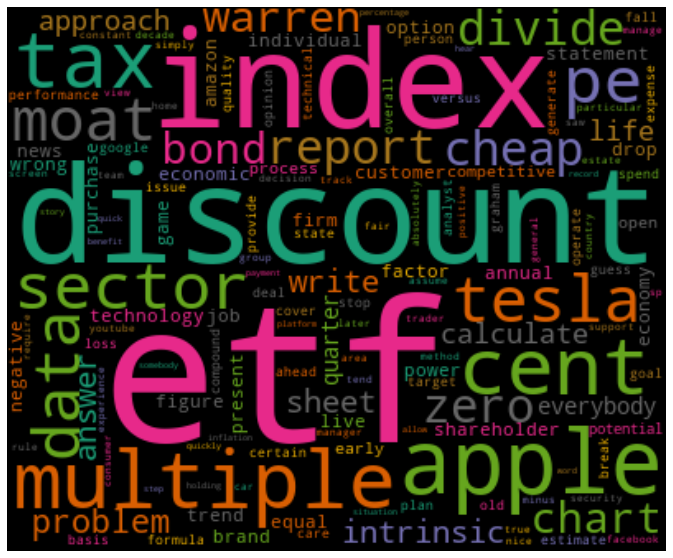

In [11]:
wordcloud(df_videos_cleaned_v8, 'Transcript')

#### Visualizing Word2Vec Word Embeddings using t-SNE

<ipython-input-27-ba83a3f632e1>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


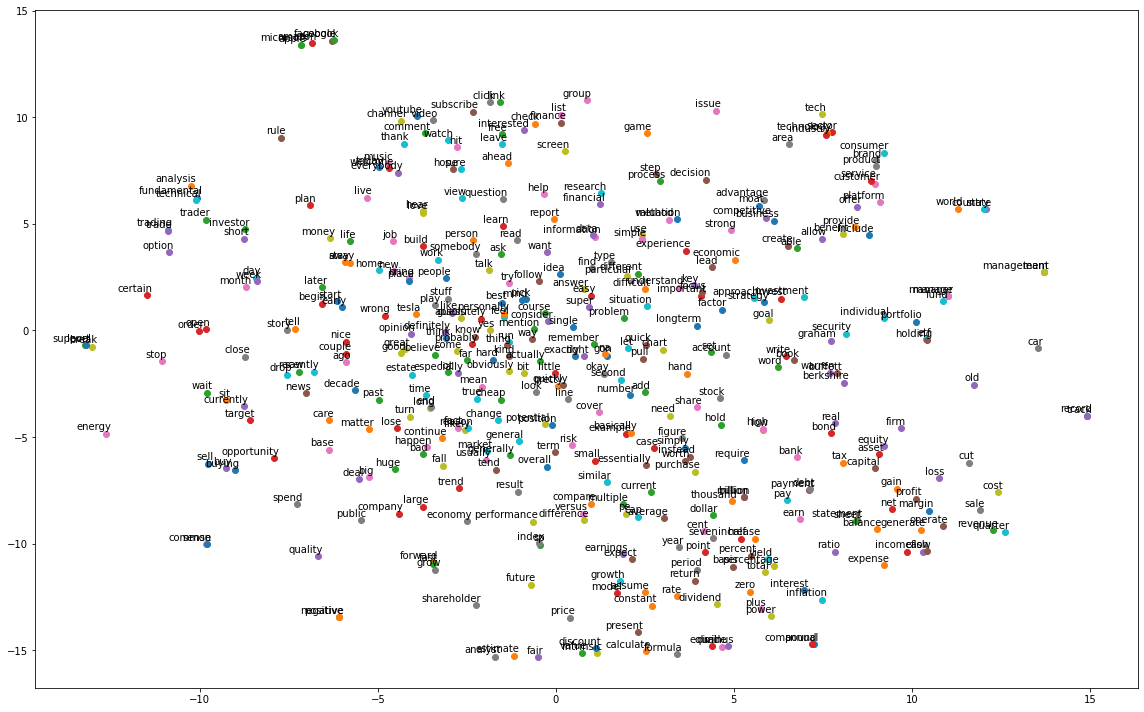

In [29]:
word2vec_plot(df_videos_cleaned_v8, 'Transcript', 900, 5)

In [37]:
word2vec_most_similar(df_videos_cleaned_v8, 'Transcript', 900, 5, 'technical')

<ipython-input-6-c8f2a29a81cf>:13: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  return model.most_similar(word)


[('fundamental', 0.7967236042022705),
 ('trading', 0.7802362442016602),
 ('trader', 0.768281102180481),
 ('analysis', 0.7510438561439514),
 ('chart', 0.7161670923233032),
 ('short', 0.6809226870536804),
 ('trade', 0.672147810459137),
 ('break', 0.5839399099349976),
 ('level', 0.5792834162712097),
 ('support', 0.5770994424819946)]

#### Identifying bad quality videos with keyword frequency

In [14]:
df_matrix_transcript = document_term_matrix_df(df_videos_cleaned_v8, 'Transcript', CountVectorizer)

In [15]:
bad_videos_1 = df_matrix_transcript[
                         (df_matrix_transcript['support']>=1) 
                       & (df_matrix_transcript['resistance']>=1)
                        ].sort_values('resistance', ascending=False)

transcript_technical = bad_videos(df_videos_cleaned_v8, bad_videos_1).drop([605, 915, 245])[:40]

#### Sentiment analysis

In [16]:
transcript_technical_sent = sentiment_analysis(transcript_technical, 'Transcript')

In [17]:
transcript_technical_pos = transcript_technical_sent[transcript_technical_sent['Sentiment Score']>0.9]

In [49]:
transcript_technical_pos.loc[[198, 1334, 295, 148, 201], ['Title']]

,Title
198,Technical Analysis Secrets: What Most Trading Gurus Will Never Tell You (by Rayner Teo)
1334,Technically Speaking: Trading the Trend (Weeks to Months) | Long-Term Investing | 4-4-19
295,Finding Stocks on Sale | Weighing the Competition: Look for Moats | Michael Fairbourn | 5-21-19
148,🚨🚀 HUGE TESLA Stock Price Prediction!! Fundamental and Technical Analysis on Tesla Stock #TSLA
201,MARA Stock WILL 10X Your Money! | MARA Stock Technical And Fundamental Analysis


### Video title word embeddings and frequency

#### Visualizing Word2Vec Word Embeddings using t-SNE

In [18]:
df_videos_cleaned_v8_title = title_preprocessing(df_videos_cleaned_v8)

In [19]:
# word2vec_plot(df_videos_cleaned_v8_title, 'Title', 10, 10)

In [20]:
word2vec_most_similar(df_videos_cleaned_v8_title, 'Title', 10, 5, 'programming')

<ipython-input-6-c8f2a29a81cf>:13: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  return model.most_similar(word)


[('  ', 0.9994732737541199),
 ('term', 0.9994237422943115),
 ('stock', 0.9994199275970459),
 ('valuation', 0.9994071125984192),
 ('best', 0.9993997812271118),
 ('value', 0.9993984699249268),
 ('advantage', 0.9993880391120911),
 ('growth', 0.9993767142295837),
 ('warren', 0.9993725419044495),
 ('year', 0.9993722438812256)]

#### Identifying bad quality videos with keyword frequency

In [21]:
df_matrix_title = document_term_matrix_df(df_videos_cleaned_v8_title, 'Title', CountVectorizer)

In [22]:
bad_videos_2 = df_matrix_title[(df_matrix_title['programming']>=1)]
bad_videos_3 = df_matrix_title[(df_matrix_title['python']>=1)]
bad_videos_4 = df_matrix_title[(df_matrix_title['app']>=1)]

In [23]:
title_programming = bad_videos(df_videos_cleaned_v8_title, bad_videos_2)
title_python = bad_videos(df_videos_cleaned_v8_title, bad_videos_3)
title_app = bad_videos(df_videos_cleaned_v8_title, bad_videos_4)

### Filtering out the bad quality videos

In [24]:
rows_to_drop = pd.concat([title_programming, title_python, title_app, transcript_technical_pos.drop('Sentiment Score', axis=1)]
                        ).drop_duplicates(subset='Video_ID').index

df_videos_cleaned_v9 = df_videos_cleaned_v8.drop(rows_to_drop).reset_index(drop=True)

### Pickle the modified dataframe 

In [25]:
pickle_df('df_videos_cleaned_v9')